In [1]:
import numpy as np
import pandas as pd
from network import *
from data_process import *
from util import *

import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

os.environ['CUDA_VISIBLE_DEVICES'] = "0"


In [48]:
def get_classes_name():
    dic = dic_ESC50()
    class_names = []
    for i in range(50):
        class_names.append(dic[i])
    return class_names


def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > 0.0:
            plt.text(j, i, format(cm[i, j], fmt), fontsize=7,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('\nTrue label', fontsize=16)
    plt.xlabel('Predicted label\n', fontsize=16)


def test(model, test_pkl):
    model.eval()
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []
    
    fs = 44100
    win_size = int(fs * 1.5)
    stride = int(fs * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent

            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
            wins_data.append(win_data)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)

        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data = torch.from_numpy(wins_data).type(torch.FloatTensor) # (N, 1L, 24002L)
        label = torch.LongTensor([label])


        data, label = data.cuda(), label.cuda()
        data, label = Variable(data, volatile=True), Variable(label)

        # print data.size()
        output = model(data)

        output = torch.sum(output, dim=0, keepdim=True)
#         output = torch.max(output, dim=0, keepdim=True)[0]
    

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix

    
def test_logmel(model, test_pkl):
    model.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        
        feats = []
        
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=64)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]  # (40, 441)
            delta = librosa.feature.delta(logmel)
            
            feat = np.stack((logmel, delta))
#             feat = logmel[np.newaxis, :]
            feats.append(feat)

        if len(feats) == 0:
            print(item['key'])

        feats = np.array(feats)
        
        data = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data, label = data.cuda(), label.cuda()
        data, label = Variable(data, volatile=True), Variable(label)
        output = model(data)
        output = torch.sum(output, dim=0, keepdim=True)

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix
    

def test_joint(model_wave, model_logmel, test_pkl):
    model_wave.eval()
    model_logmel.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=96)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]
#             delta = librosa.feature.delta(logmel)
            
#             feat = np.stack((logmel, delta))
            feat = logmel[np.newaxis, :]
            feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor) 
        data_logmel = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data_wave, data_logmel, label = data_wave.cuda(), data_logmel.cuda(), label.cuda()
        data_wave, data_logmel, label = Variable(data_wave, volatile=True), Variable(data_logmel, volatile=True), Variable(label)

        # print data.size()
        output_wave = model_wave(data_wave)
        output_logmel = model_logmel(data_logmel)
        
        output_wave = torch.sum(output_wave, dim=0, keepdim=True)
        output_logmel = torch.sum(output_logmel, dim=0, keepdim=True)
        
        w, u = 0.5, 0.5
        output = w * output_wave + u * output_logmel
#         print output
        # print output

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix

def test_joint3(model_srf, model_mrf, model_lrf, test_pkl):
    model_srf.eval()
    model_mrf.eval()
    model_lrf.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
#             melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=64)  # (40, 442)
#             logmel = librosa.logamplitude(melspec)[:,:441]
#             delta = librosa.feature.delta(logmel)
            
#             feat = np.stack((logmel, delta))
# #             feat = logmel[np.newaxis, :]
#             feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor)
        
        label = torch.LongTensor([label])


        data_wave, label = data_wave.cuda(), label.cuda()
        data_wave, label = Variable(data_wave, volatile=True), Variable(label)

        # print data.size()
        output_srf = model_srf(data_wave)
        output_mrf = model_mrf(data_wave)
        output_lrf = model_lrf(data_wave)
        

        output_srf = torch.sum(output_srf, dim=0, keepdim=True)
        output_mrf = torch.sum(output_mrf, dim=0, keepdim=True)
        output_lrf = torch.sum(output_lrf, dim=0, keepdim=True)

        output = output_srf + output_mrf + output_lrf

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix

def test_joint4(model_srf, model_mrf, model_lrf, model_logmel, test_pkl):
    model_srf.eval()
    model_mrf.eval()
    model_lrf.eval()
    model_logmel.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=64)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]
            delta = librosa.feature.delta(logmel)
            
            feat = np.stack((logmel, delta))
#             feat = logmel[np.newaxis, :]
            feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor) 
        data_logmel = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data_wave, data_logmel, label = data_wave.cuda(), data_logmel.cuda(), label.cuda()
        data_wave, data_logmel, label = Variable(data_wave, volatile=True), Variable(data_logmel, volatile=True), Variable(label)

        # print data.size()
        output_srf = model_srf(data_wave)
        output_mrf = model_mrf(data_wave)
        output_lrf = model_lrf(data_wave)
        output_logmel = model_logmel(data_logmel)
        
        output_srf = torch.sum(output_srf, dim=0, keepdim=True)
        output_mrf = torch.sum(output_mrf, dim=0, keepdim=True)
        output_lrf = torch.sum(output_lrf, dim=0, keepdim=True)
        
#         print output_wave
        output_logmel = torch.sum(output_logmel, dim=0, keepdim=True)
#         print output_logmel
        output = output_srf + output_mrf + output_lrf + output_logmel



        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix


def test_transfer(model_transfer, test_pkl):
    model_transfer.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        logmels = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=96)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]
            feat = logmel[np.newaxis, :, :]
#             feat = np.stack((logmel, delta))
            feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor) 
        data_feats = torch.from_numpy(feats).type(torch.FloatTensor) 
        label = torch.LongTensor([label])

        data_wave, data_feats, label = data_wave.cuda(), data_feats.cuda(), label.cuda()
        data_wave, data_feats, label = Variable(data_wave, volatile=True), Variable(data_feats, volatile=True), Variable(label)

        # print data.size()
        output = model_transfer(data_wave, data_feats)
        output = torch.sum(output, dim=0, keepdim=True)

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix


def test_joint_transfer(model_transfer, model_logmel, test_pkl):
    model_transfer.eval()
    model_logmel.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        logmels = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=96)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]
            feat = logmel[np.newaxis, :, :]
#             feat = np.stack((logmel, delta))
            feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor) 
        data_feats = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data_wave, data_feats, label = data_wave.cuda(), data_feats.cuda(), label.cuda()
        data_wave, data_feats, label = Variable(data_wave, volatile=True), Variable(data_feats, volatile=True), Variable(label)

        # print data.size()
        output_wave = model_transfer(data_wave, data_feats)
        output_logmel = model_logmel(data_feats)
        
        output_wave = torch.sum(output_wave, dim=0, keepdim=True)
        output_logmel = torch.sum(output_logmel, dim=0, keepdim=True)
        
        w, u = 0.5, 0.5
        output = w * output_wave + u * output_logmel
#         print output
        # print output

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix

In [3]:
class_names = get_classes_name()
print(class_names)

['Hand saw', 'Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects (flying)', 'Sheep', 'Crow', 'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking - sipping', 'Door knock', 'Mouse click', 'Keyboard typing', 'Door - wood creaks', 'Can opening', 'Washing machine', 'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks']


### M9_transfer

In [4]:
test_acc = []
total_cnf_matrix = []
for fold_num in range(5):
    model_name = '../model/M9_fixed_logmel_fold' + str(fold_num) + '_p2_v3_more.pkl'
    model = torch.load(model_name)
    model.changePhase(2)
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_transfer(model, testPkl)
    test_acc.append(acc)
    total_cnf_matrix.append(cnf_matrix)

/home/zbq/work/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'network.M9_fixed_logmel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



Test set: Average loss: 10.1267, TestACC: 319/400 79.75%


Test set: Average loss: 11.8894, TestACC: 317/400 79.25%


Test set: Average loss: 12.8947, TestACC: 312/400 78.00%


Test set: Average loss: 8.9101, TestACC: 328/400 82.00%


Test set: Average loss: 12.1787, TestACC: 306/400 76.50%



In [50]:

matrix = total_cnf_matrix[0] + total_cnf_matrix[1] + total_cnf_matrix[2] + total_cnf_matrix[3] + total_cnf_matrix[4] 

np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 13))
plot_confusion_matrix(matrix, classes=class_names, normalize=True)
#                       title='Confusion matrix on' + str(fold_num))

plt.tight_layout()
# plt.show()
plt.savefig('cf_matrix.pdf')

### 单独测试wave特征

In [16]:
test_acc = []
total_cnf_matrix = []
for fold_num in range(5):
    model_name = '../model/M9_fixed_logmel_fold' + str(fold_num) + '_p2_v3_more.pkl'
    model = torch.load(model_name)
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test(model, testPkl)
    test_acc.append(acc)
    total_cnf_matrix.append(cnf_matrix)

RuntimeError: expected Variable as element 1 in argument 0, but got tuple

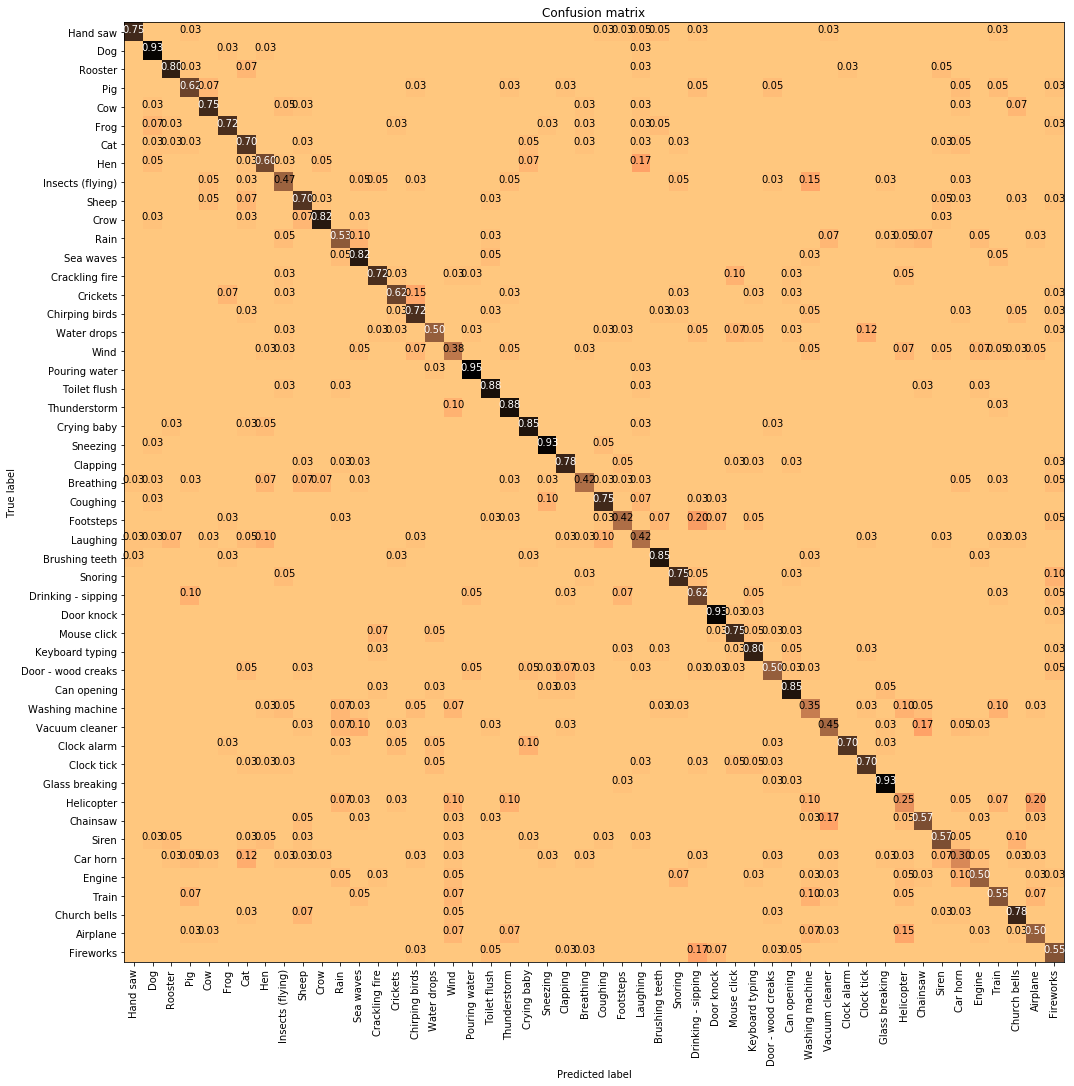

In [51]:
matrix = total_cnf_matrix[0] + total_cnf_matrix[1] + total_cnf_matrix[2] + total_cnf_matrix[3] + total_cnf_matrix[4] 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(matrix, classes=class_names, normalize=True)
#                       title='Confusion matrix on' + str(fold_num))

plt.show()

### 单独测试logmel特征

In [7]:
test_acc = []
for fold_num in range(5):
    model_name = '../model/M9Logmel_fold' + str(fold_num) + '_v1_epoch100.pkl'
    model = torch.load(model_name)
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_logmel(model, testPkl)
    test_acc.append(acc)


Test set: Average loss: 20.8227, TestACC: 282/400 70.50%


Test set: Average loss: 28.6489, TestACC: 253/400 63.25%


Test set: Average loss: 19.8636, TestACC: 290/400 72.50%


Test set: Average loss: 23.9497, TestACC: 276/400 69.00%


Test set: Average loss: 26.4574, TestACC: 251/400 62.75%



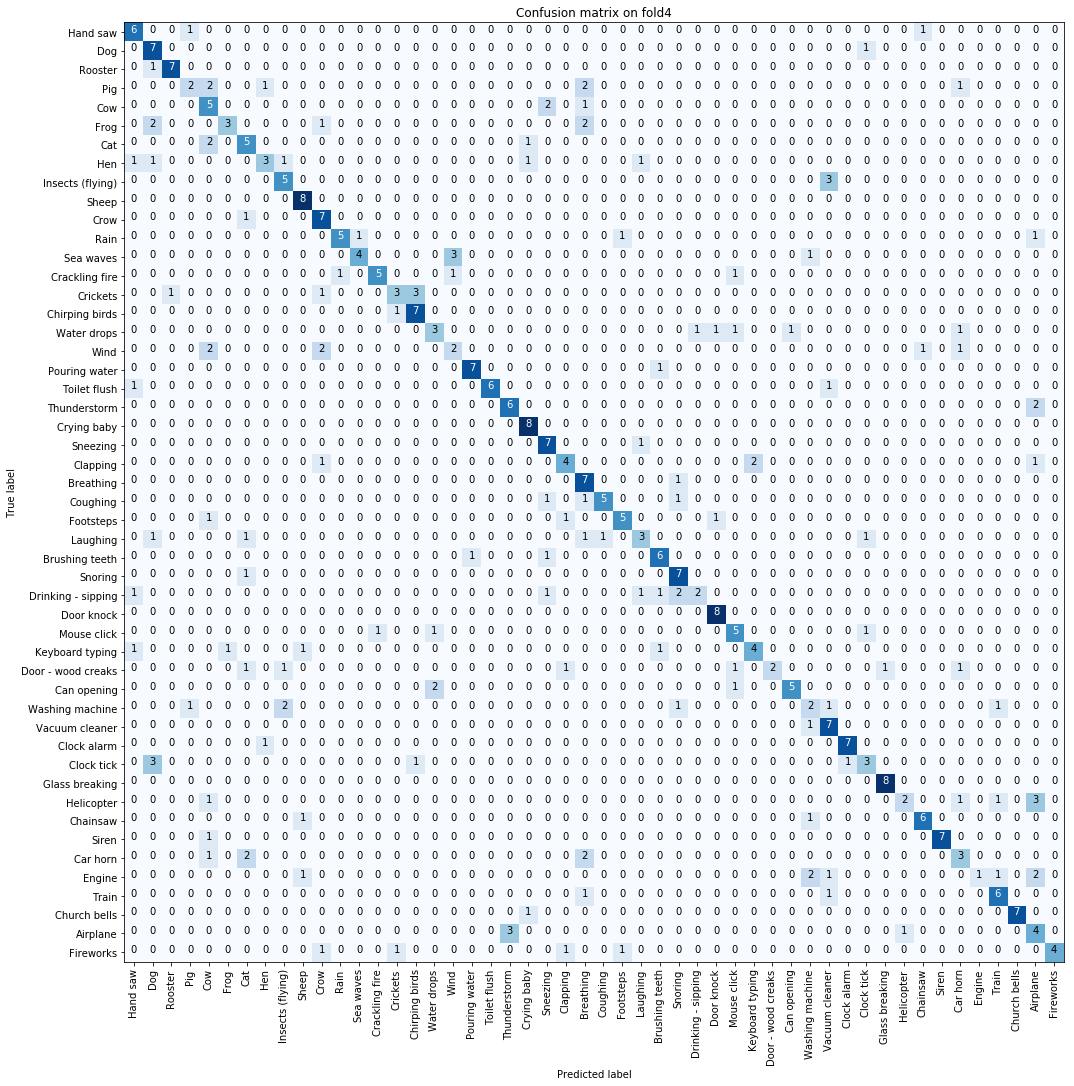

In [8]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix on fold' + str(fold_num))

plt.show()

### wave和logmel特征共同测试

In [4]:
test_acc = []
total_cnf_matrix = []
for fold_num in range(5):
    model_wave_name = '../model/M9_fixed_logmel_fold' + str(fold_num) + '_p2_v3.pkl'
    model_logmel_name = '../model/M9Logmel_v3_fold' + str(fold_num) + '.pkl'
    
    model_wave = torch.load(model_wave_name) 
    model_wave.changePhase(1)
    model_logmel = torch.load(model_logmel_name)
    
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_joint(model_wave, model_logmel, testPkl)
    test_acc.append(acc)
    total_cnf_matrix.append(cnf_matrix)


/home/zbq/work/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'network.M9_fixed_logmel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


torch.Size([18, 1, 66150])
torch.Size([18, 2, 96, 441])


RuntimeError: Given groups=1, weight[64, 6, 3, 3], so expected input[18, 2, 96, 441] to have 6 channels, but got 2 channels instead

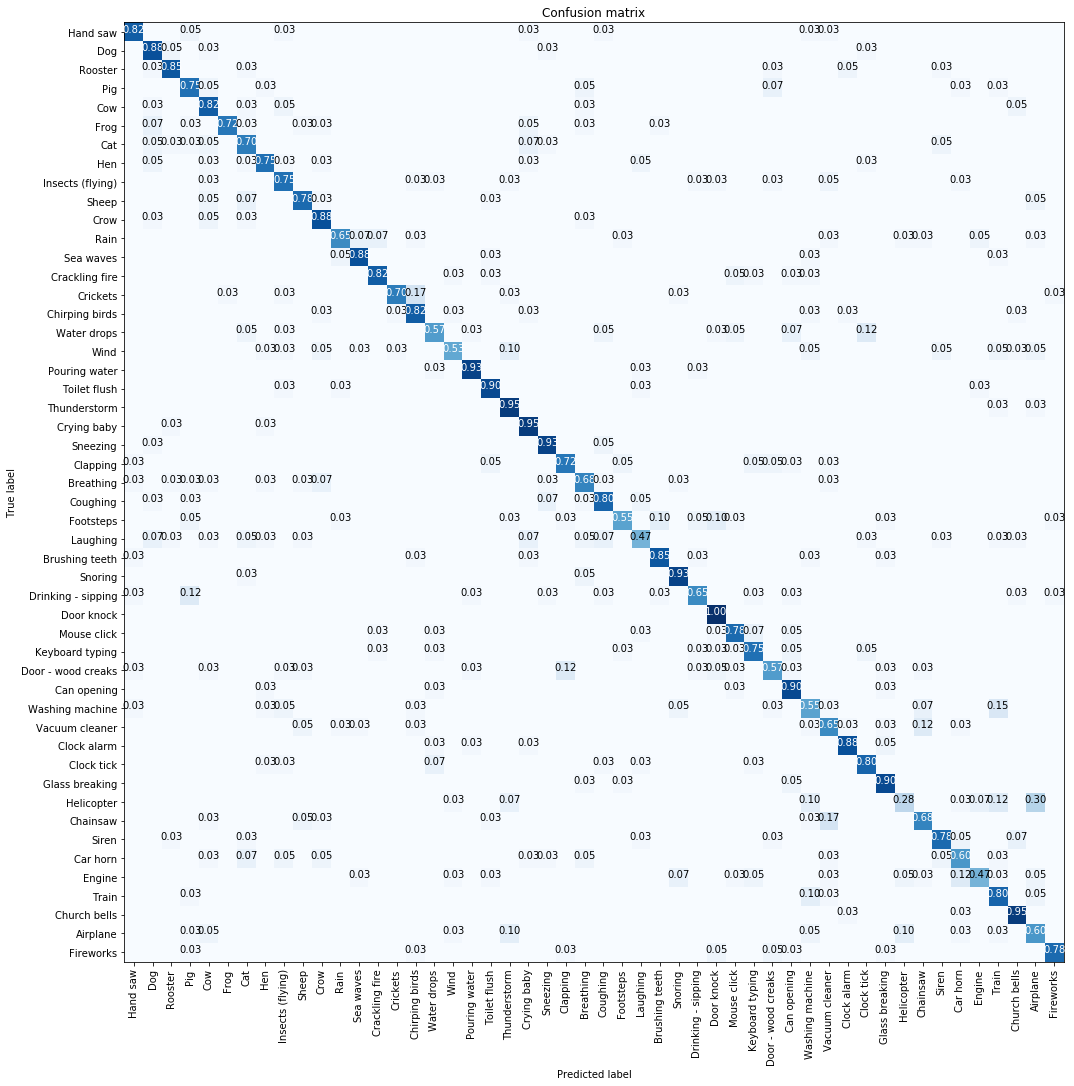

In [56]:
matrix = total_cnf_matrix[0] + total_cnf_matrix[1] + total_cnf_matrix[2] + total_cnf_matrix[3] + total_cnf_matrix[4] 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(matrix, classes=class_names, normalize=True)
#                       title='Confusion matrix on' + str(fold_num))

plt.show()

### multiscale特征单独训练后与logmel模型概率相加

In [10]:
test_acc = []
for fold_num in range(5):
    model_srf_name = '../model/M9_srf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_mrf_name = '../model/M9_mrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_lrf_name = '../model/M9_lrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_logmel_name = '../model/M9Logmel_fold' + str(fold_num) + '_v1_epoch100.pkl'
    
    model_srf = torch.load(model_srf_name) 
    model_mrf = torch.load(model_mrf_name)
    model_lrf = torch.load(model_lrf_name)
    model_logmel = torch.load(model_logmel_name)
    
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_joint4(model_srf, model_mrf, model_lrf, model_logmel, testPkl)
    test_acc.append(acc)
    
#     np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     plt.figure(figsize=(15, 15))
#     plot_confusion_matrix(cnf_matrix, classes=class_names,
#                           title='Confusion matrix on fold' + str(fold_num))

#     plt.show()



Test set: Average loss: 52.0070, TestACC: 303/400 75.75%


Test set: Average loss: 52.7684, TestACC: 293/400 73.25%


Test set: Average loss: 47.2480, TestACC: 308/400 77.00%


Test set: Average loss: 38.8772, TestACC: 303/400 75.75%


Test set: Average loss: 48.9153, TestACC: 289/400 72.25%



In [12]:
# test_acc = [75.75, 73.25, 77, 75.75, 72.25]
test_acc.extend([np.average(test_acc), np.std(test_acc)])
df = pd.DataFrame([test_acc])
df.columns = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4', 'average', 'std']
df.index = ['Test']
df.head()

,fold0,fold1,fold2,fold3,fold4,average,std
Test,79.0,76.5,79.25,78.25,73.75,77.35,2.040833


# 